<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/ML-models/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = "/content/drive/My Drive/Dataset4"

# Verify dataset structure
os.listdir(dataset_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Testing', 'Validation', 'Training', 'raw', 'processed', 'testing']

In [23]:
!pip install torch torchvision transformers torch-geometric


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT Model loaded successfully!
Epoch 1, Loss: 0.7747597843408585
Epoch 2, Loss: 0.4823075905442238
Epoch 3, Loss: 0.3938446044921875
Epoch 4, Loss: 0.2933787703514099
Epoch 5, Loss: 0.2293228581547737
ViT model saved at /content/drive/My Drive/VIT_model.pth


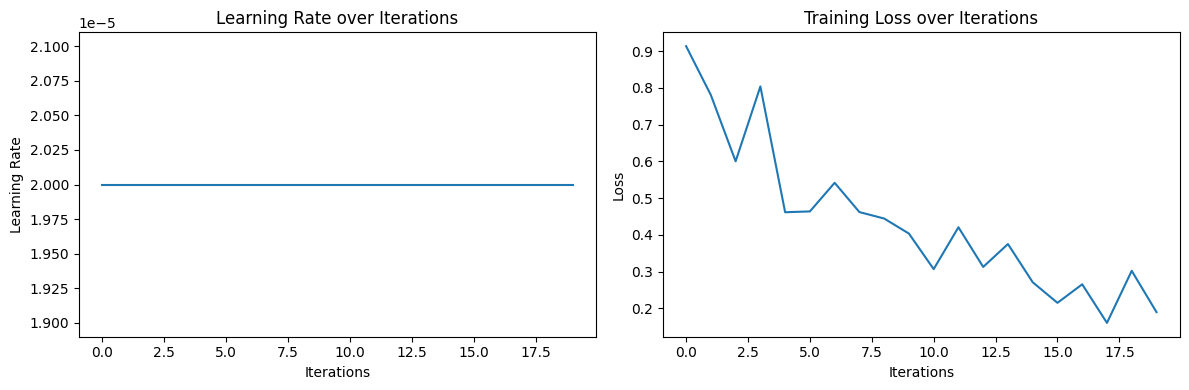

In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import matplotlib.pyplot as plt

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Dataset
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "Training"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load Pretrained ViT Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import ViTForImageClassification

# Load Pretrained ViT Model (Fixing size mismatch issue)
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=2,
    ignore_mismatched_sizes=True  # ✅ This ignores size mismatches in classifier layer
)

model.to(device)
print("ViT Model loaded successfully!")


# Define Optimizer & Loss
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

lr_history = []
loss_history = []

# Train ViT
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store learning rate and loss
        lr_history.append(optimizer.param_groups[0]['lr'])  # Get current learning rate
        loss_history.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


# Save ViT Model
vit_model_path = "/content/drive/My Drive/VIT_model.pth"
torch.save(model.state_dict(), vit_model_path)
print(f"ViT model saved at {vit_model_path}")
# Visualization
plt.figure(figsize=(12, 4))

# Plot learning rate
plt.subplot(1, 2, 1)
plt.plot(lr_history)
plt.title('Learning Rate over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title('Training Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()



In [27]:
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image # Import the Image class from PIL


# Load test dataset
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "Training"), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"ViT Accuracy: {accuracy * 100:.2f}%")

# Classification Report (Precision, Recall, F1-Score)
print("ViT Classification Report:\n", classification_report(all_labels, all_preds, target_names=["Fake", "Real"]))

# Function to predict real or fake
def predict_real_or_fake(image_path):
    image = Image.open(image_path) # Now Image is defined and can be used
    image = transform(image).unsqueeze(0).to(device)  # Preprocess and move to device
    with torch.no_grad():
        output = model(pixel_values=image).logits
        pred = torch.argmax(output, dim=1).item()
    return "Real" if pred == 1 else "Fake"

# Example usage
sample_image_path = "/content/drive/MyDrive/Dataset4/Validation/Fake/10f.jpg"  # Replace with your image path
prediction = predict_real_or_fake(sample_image_path)
print(f"Prediction for {sample_image_path}: {prediction}")

ViT Accuracy: 98.44%
ViT Classification Report:
               precision    recall  f1-score   support

        Fake       0.97      1.00      0.98        32
        Real       1.00      0.97      0.98        32

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.98      0.98      0.98        64

Prediction for /content/drive/MyDrive/Dataset4/Validation/Fake/10f.jpg: Fake
